#Customer Segreggation using RFM Analysis

In [350]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
#%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import time, warnings
import datetime as dt
warnings.filterwarnings("ignore")

In [351]:
# Load the data with specified encoding and data types
data = pd.read_csv(
    './data.csv',
    encoding="ISO-8859-1",
    dtype={
        'CustomerID': str,
        'InvoiceNo': str,
        'StockCode': str,
        'Description': str,
        'Quantity': int,
        'UnitPrice': float,
        'Country': str
    },
    parse_dates=['InvoiceDate']
)

# Display the data types to verify
print(data.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int32
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


In [352]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [353]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


In [354]:
clean_data=data.drop(columns=["InvoiceNo","StockCode","Description"]).dropna()

In [355]:
clean_data.describe()

,Quantity,InvoiceDate,UnitPrice
count,406829.000000,406829,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-31 11:48:00,1.950000
75%,12.000000,2011-10-20 13:06:00,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,248.693370,NaN,69.315162


In [356]:
clean_data["Country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [357]:
# Group by 'Country' and count the number of occurrences
grouped_data = clean_data.groupby('Country').count()

# Sort by 'Quantity' column in descending order
sorted_data = grouped_data.sort_values(by='Quantity', ascending=False)

In [358]:
sorted_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID
Country,,,,
United Kingdom,361878,361878,361878,361878
Germany,9495,9495,9495,9495
France,8491,8491,8491,8491
EIRE,7485,7485,7485,7485
Spain,2533,2533,2533,2533


In [359]:
#Filter data for 'United Kingdom'
uk_data = clean_data[clean_data["Country"] == "United Kingdom"]

uk_data.drop(inplace=True,columns=["Country"])

# Display the filtered data
print(uk_data)


        Quantity         InvoiceDate  UnitPrice CustomerID
0              6 2010-12-01 08:26:00       2.55      17850
1              6 2010-12-01 08:26:00       3.39      17850
2              8 2010-12-01 08:26:00       2.75      17850
3              6 2010-12-01 08:26:00       3.39      17850
4              6 2010-12-01 08:26:00       3.39      17850
...          ...                 ...        ...        ...
541889        12 2011-12-09 12:31:00       1.95      15804
541890         8 2011-12-09 12:49:00       2.95      13113
541891        24 2011-12-09 12:49:00       1.25      13113
541892        24 2011-12-09 12:49:00       8.95      13113
541893        10 2011-12-09 12:49:00       7.08      13113

[361878 rows x 4 columns]


# Recency

In [360]:
# Grouping by CustomerID and aggregating by maximum InvoiceDate
customer_recency_data = uk_data.groupby('CustomerID').agg({'InvoiceDate': 'max'})

# Renaming the columns
customer_recency_data.columns = ["Recent InvoiceDate"]

# Resetting the index to make CustomerID a column
customer_recency_data = customer_recency_data.reset_index()

customer_recency_data.head()

,CustomerID,Recent InvoiceDate
0,12346,2011-01-18 10:17:00
1,12747,2011-12-07 14:34:00
2,12748,2011-12-09 12:20:00
3,12749,2011-12-06 09:56:00
4,12820,2011-12-06 15:12:00


In [361]:
# Calculate the "Recency" as the difference between now and "InvoiceDate"
customer_recency_data["Recency"] = dt.datetime.now() - customer_recency_data["Recent InvoiceDate"]

# Extract the number of days from the "Recency" timedelta
customer_recency_data["Recency"] = customer_recency_data["Recency"].dt.days

# Display the first few rows to verify
customer_recency_data.head()

,CustomerID,Recent InvoiceDate,Recency
0,12346,2011-01-18 10:17:00,4876
1,12747,2011-12-07 14:34:00,4552
2,12748,2011-12-09 12:20:00,4551
3,12749,2011-12-06 09:56:00,4554
4,12820,2011-12-06 15:12:00,4553


In [362]:
# Calculate the interquartile range (IQR) for Frequency_normalized
Q1 = customer_recency_data["Recency"].quantile(0.25)
Q3 = customer_recency_data["Recency"].quantile(0.75)
IQR = Q3 - Q1

# Filter out the data points within the IQR range
customer_recency_data = customer_recency_data[(customer_recency_data["Recency"] >= Q1 - 1.5 * IQR) & (customer_recency_data["Recency"] <= Q3 + 1.5 * IQR)]

# Display the filtered data
print(customer_freq_data.head())


  CustomerID  Frequency  Frequency_normalized
0      12747        103              0.447368
3      12820         59              0.254386
4      12821          6              0.021930
5      12822         47              0.201754
6      12823          5              0.017544


In [363]:
# Normalize the "Recency" column using min-max normalization

min_recency=customer_data["Recency"].min()
max_recency=customer_data["Recency"].max()

# Calculate min-max normalization using apply and lambda function
customer_data["Recency_normalized"] = customer_data["Recency"].apply(lambda x: (x - min_recency) / (max_recency - min_recency))

#Reverse sacled as lowest difference should be highest value
customer_data["Recency_normalized"]=1-customer_data["Recency_normalized"]


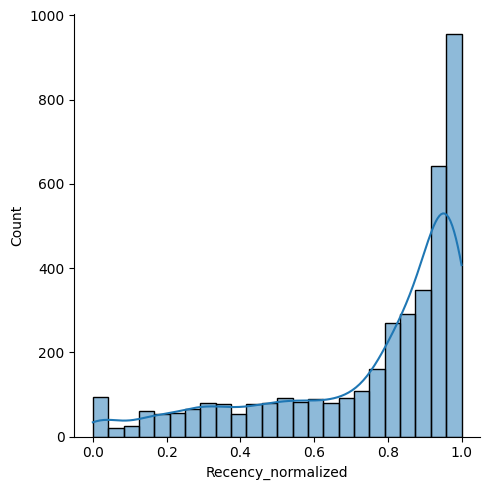

In [364]:
# Create a distribution plot for Recency_normalized
sns.displot(customer_data["Recency_normalized"], kde=True)

## Frequency

In [365]:
# Grouping by CustomerID and aggregating by count to get frequency
customer_freq_data = uk_data.groupby('CustomerID').size().reset_index(name='Frequency')

# Displaying the result
print(customer_freq_data.head())


  CustomerID  Frequency
0      12346          2
1      12747        103
2      12748       4642
3      12749        231
4      12820         59


In [366]:
# Calculate the interquartile range (IQR) for Frequency_normalized
Q1 = customer_freq_data["Frequency"].quantile(0.25)
Q3 = customer_freq_data["Frequency"].quantile(0.75)
IQR = Q3 - Q1

# Filter out the data points within the IQR range
customer_freq_data = customer_freq_data[(customer_freq_data["Frequency"] >= Q1 - 1.5 * IQR) & (customer_freq_data["Frequency"] <= Q3 + 1.5 * IQR)]

# Display the filtered data
print(customer_freq_data.head())


  CustomerID  Frequency
0      12346          2
1      12747        103
4      12820         59
5      12821          6
6      12822         47


In [367]:
# Normalize the "Frequency" column using min-max normalization

min_freq=customer_freq_data["Frequency"].min()
max_freq=customer_freq_data["Frequency"].max()

# Calculate min-max normalization using apply and lambda function
customer_freq_data["Frequency_normalized"] = customer_freq_data["Frequency"].apply(lambda x: (x - min_freq) / (max_freq - min_freq))

print(customer_freq_data.head())

  CustomerID  Frequency  Frequency_normalized
0      12346          2              0.004425
1      12747        103              0.451327
4      12820         59              0.256637
5      12821          6              0.022124
6      12822         47              0.203540


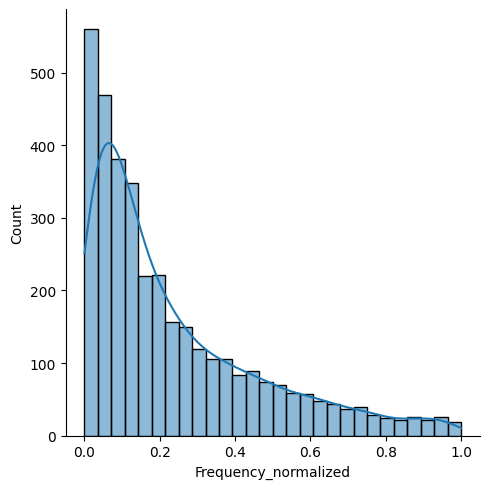

In [368]:
# Create a distribution plot for Recency_normalized
sns.displot(customer_freq_data["Frequency_normalized"], kde=True)

# Monetory Value

In [369]:
# Grouping by CustomerID and aggregating by sum of the product of 'UnitPrice' and 'Quantity'
customer_monetary_data=[]
customer_monetary_data = uk_data[["CustomerID","UnitPrice","Quantity"]]

# Creating a new column for the product of 'UnitPrice' and 'Quantity'
customer_monetary_data['Total Price'] = customer_monetary_data['UnitPrice'] * customer_monetary_data['Quantity']

# Grouping by CustomerID and aggregating by sum Monetary
customer_monetary_data = customer_monetary_data.groupby('CustomerID').agg({'Total Price': 'sum'})

# Renaming the columns
customer_monetary_data.columns = ["Monetary"]

# Resetting the index to make CustomerID a column
customer_monetary_data = customer_monetary_data.reset_index()


In [370]:

# Displaying the result
print(customer_monetary_data.head(10))

  CustomerID  Monetary
0      12346      0.00
1      12747   4196.01
2      12748  29072.10
3      12749   3868.20
4      12820    942.34
5      12821     92.72
6      12822    918.98
7      12823   1759.50
8      12824    397.12
9      12826   1468.12


In [371]:
# Calculate the interquartile range (IQR) for Frequency_normalized
Q1 = customer_monetary_data["Monetary"].quantile(0.25)
Q3 = customer_monetary_data["Monetary"].quantile(0.75)
IQR = Q3 - Q1

# Filter out the data points within the IQR range
customer_monetary_data = customer_monetary_data[(customer_monetary_data["Monetary"] >= Q1 - 1.5 * IQR) & (customer_monetary_data["Monetary"] <= Q3 + 1.5 * IQR)]

# Display the filtered data
print(customer_monetary_data.head())


  CustomerID  Monetary
0      12346      0.00
4      12820    942.34
5      12821     92.72
6      12822    918.98
7      12823   1759.50


In [372]:
# Normalize the "Monetary" column using min-max normalization

min_mon=customer_monetary_data["Monetary"].min()
max_mon=customer_monetary_data["Monetary"].max()

# Calculate min-max normalization using apply and lambda function
customer_monetary_data["Monetary_normalized"] = customer_monetary_data["Monetary"].apply(lambda x: (x - min_mon) / (max_mon - min_mon))

print(customer_monetary_data.head())

  CustomerID  Monetary  Monetary_normalized
0      12346      0.00             0.260923
4      12820    942.34             0.467162
5      12821     92.72             0.281216
6      12822    918.98             0.462050
7      12823   1759.50             0.646005


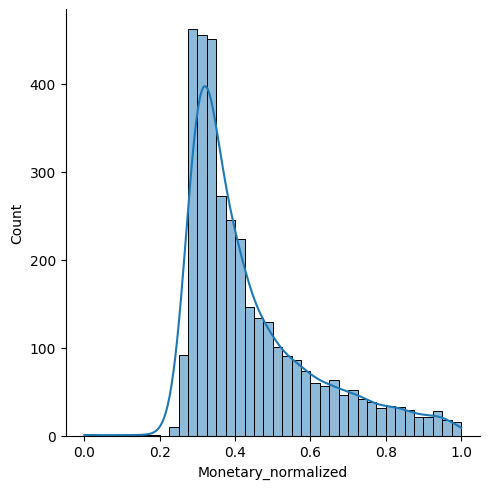

In [373]:
# Create a distribution plot for Recency_normalized
sns.displot(customer_monetary_data["Monetary_normalized"], kde=True)

In [374]:
#RFM

# Combine the normalized columns into a new DataFrame
rfm_data = pd.concat([customer_data["Recency_normalized"], customer_freq_data["Frequency_normalized"], customer_monetary_data["Monetary_normalized"]], axis=1)

# Display the first few rows of the new DataFrame
print(rfm_data.head())


   Recency_normalized  Frequency_normalized  Monetary_normalized
0            0.128686              0.004425             0.260923
1            0.997319              0.451327                  NaN
2            1.000000                   NaN                  NaN
3            0.991957                   NaN                  NaN
4            0.994638              0.256637             0.467162


In [375]:
rfm_data.dropna(inplace=True)
rfm_data

,Recency_normalized,Frequency_normalized,Monetary_normalized
0,0.128686,0.004425,0.260923
4,0.994638,0.256637,0.467162
5,0.428954,0.022124,0.281216
6,0.812332,0.203540,0.462050
7,0.801609,0.017699,0.646005
...,...,...,...
3944,0.804290,0.035398,0.298983
3945,0.257373,0.039823,0.300449
3946,0.517426,0.026549,0.278611
3947,0.981233,0.053097,0.299574


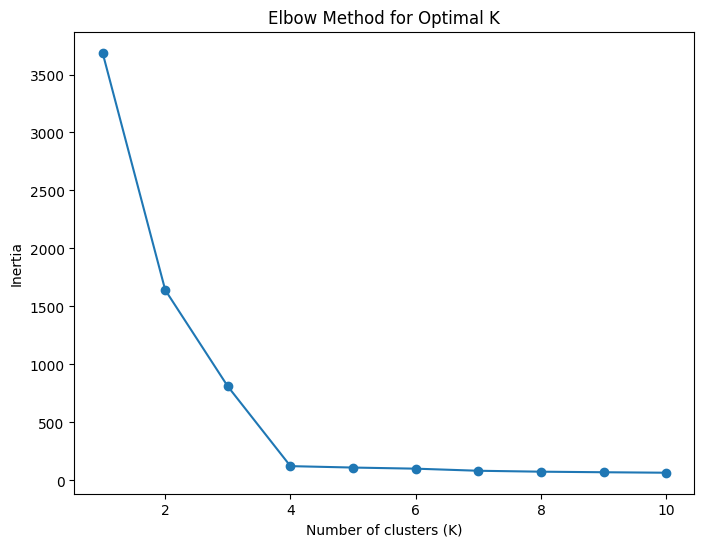

In [380]:
# Assuming rfm_data is already defined and contains the necessary data

# Define the range of K values to test
k_range = range(1, 11)

# Initialize an empty list to store inertia values for each K
inertia_values = []

# Compute the inertia for each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_data)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values to find the elbow point
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [376]:
# Instantiate the KMeans model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model to the RFM data
kmeans.fit(rfm_data)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the RFM data DataFrame
rfm_data['Cluster'] = cluster_labels

# Display the first few rows of the RFM data with cluster labels
print(rfm_data.head())


   Recency_normalized  Frequency_normalized  Monetary_normalized  Cluster
0            0.128686              0.004425             0.260923        1
4            0.994638              0.256637             0.467162        0
5            0.428954              0.022124             0.281216        1
6            0.812332              0.203540             0.462050        2
7            0.801609              0.017699             0.646005        2


In [377]:
# Grouping by Cluster and calculating the average of each RFM component
rfm_data_cluster_avg = rfm_data.groupby('Cluster').agg({
    'Recency_normalized': 'mean',
    'Frequency_normalized': 'mean',
    'Monetary_normalized': 'mean'
})

# Displaying the result
print(rfm_data_cluster_avg)


         Recency_normalized  Frequency_normalized  Monetary_normalized
Cluster                                                               
0                  0.890118              0.326204             0.527878
1                  0.312009              0.098037             0.335881
2                  0.848443              0.101792             0.352683
3                  0.907420              0.671047             0.690642


In [378]:
#Renaming

# Renaming the clusters
cluster_names = {
    0: 'Butterflies',
    1: 'Strangers',
    2: 'Barnacles',
    3: 'True Friends'
}
rfm_data_cluster_avg.rename(index=cluster_names, inplace=True)

# Renaming the column names
column_names = {
    'Recency_normalized': 'Recency',
    'Frequency_normalized': 'Frequency',
    'Monetary_normalized': 'Monetary'
}
rfm_data_cluster_avg.rename(columns=column_names, inplace=True)

# Displaying the result
print(rfm_data_cluster_avg)


               Recency  Frequency  Monetary
Cluster                                    
Butterflies   0.890118   0.326204  0.527878
Strangers     0.312009   0.098037  0.335881
Barnacles     0.848443   0.101792  0.352683
True Friends  0.907420   0.671047  0.690642


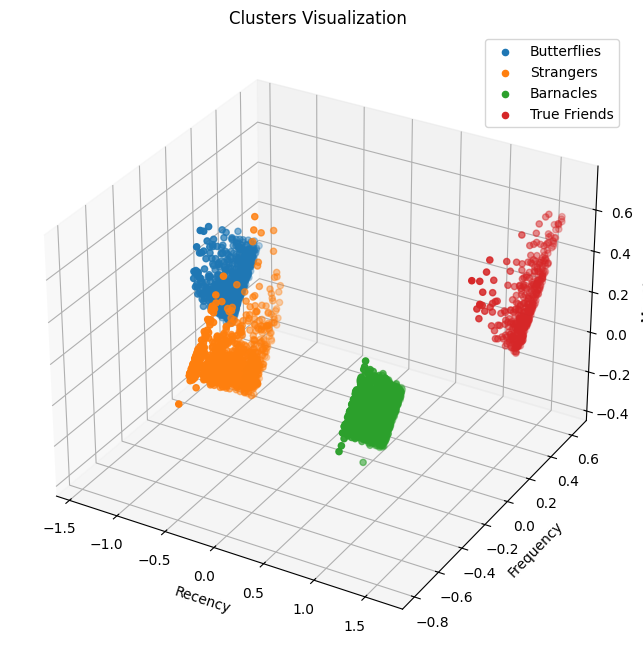

In [379]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
rfm_pca = pca.fit_transform(rfm_data)

# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for cluster in range(4):
    ax.scatter(rfm_pca[rfm_data['Cluster'] == cluster][:, 0],
               rfm_pca[rfm_data['Cluster'] == cluster][:, 1],
               rfm_pca[rfm_data['Cluster'] == cluster][:, 2],
               label=cluster_names[cluster])

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Clusters Visualization')

# Add legend
ax.legend()

# Show plot
plt.show()
